In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow
!pip install pyvi
!pip install keras

## Import lib

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

## Load data

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_uit-vsmec/datasets.csv')
data.head()

,label,text
0,trung lập,cho mình xin bài nhạc tên là gì với ạ
1,tiêu cực,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,tiêu cực,lo học đi . yêu đương lol gì hay lại thích học...
3,tích cực,uớc gì sau này về già vẫn có thể như cụ này :))
4,tích cực,mỗi lần có video của con là cứ coi đi coi lại ...


## Create Input + Label From Raw Data

In [6]:
sentiment_data = pd.DataFrame({'input': data['text'], 'label': data ['label']})
sentiment_data = sentiment_data.dropna()
sentiment_data = sentiment_data.reset_index(drop=True)
sentiment_data.head()

,input,label
0,cho mình xin bài nhạc tên là gì với ạ,trung lập
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,tiêu cực
2,lo học đi . yêu đương lol gì hay lại thích học...,tiêu cực
3,uớc gì sau này về già vẫn có thể như cụ này :)),tích cực
4,mỗi lần có video của con là cứ coi đi coi lại ...,tích cực


## Preprocessing data & Prepare Data For Training

In [7]:
input_data = sentiment_data['input'].values
input_label = sentiment_data['label'].values

label_dict = {'tiêu cực':0, 'trung lập':1, 'tích cực':2}

input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
  input_pre.append(input_text_pre_accent)
  input_pre.append(input_text_pre_no_accent)
  label_with_accent.append(input_label[idx])
  label_with_accent.append(input_label[idx])

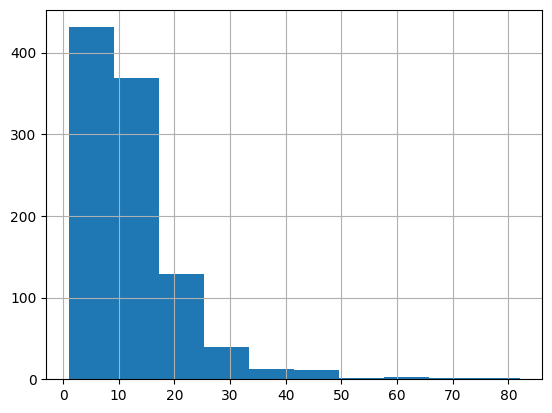

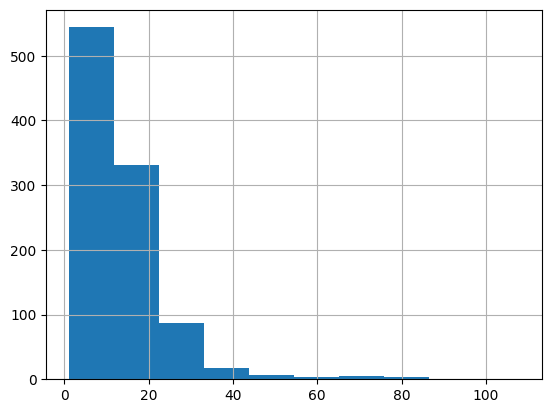

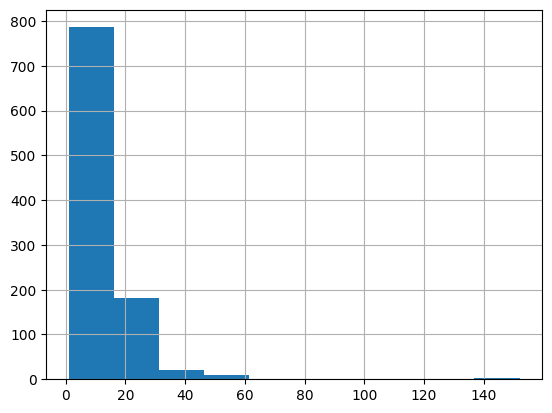

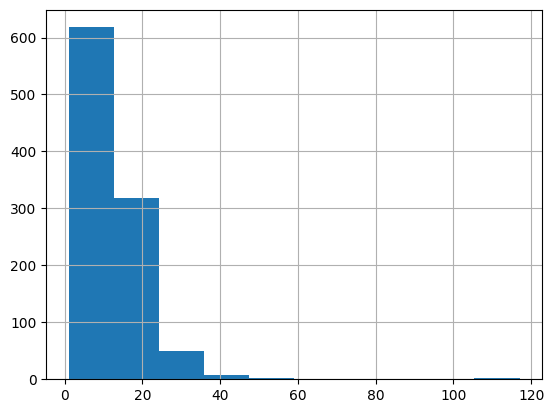

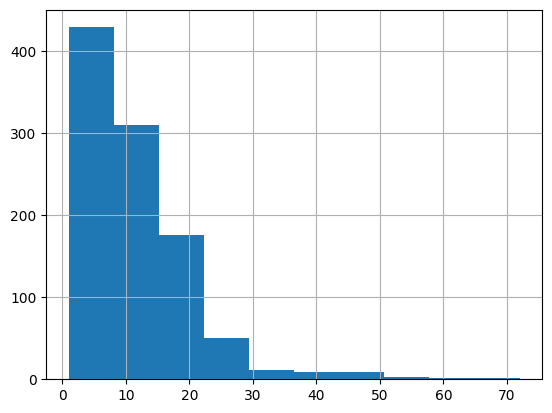

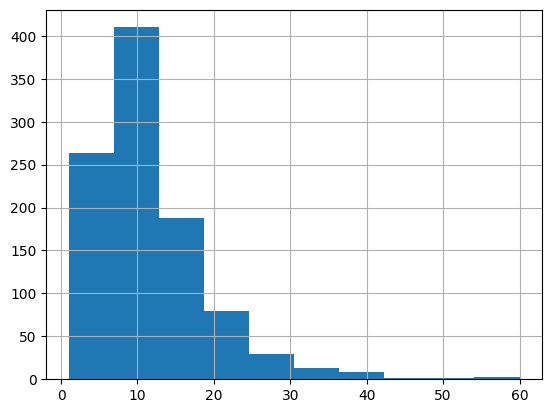

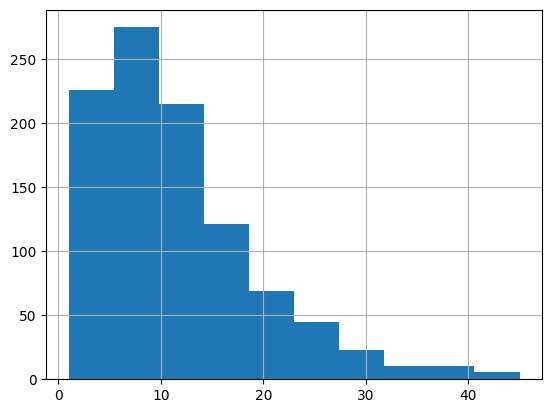

In [8]:
#visualize xem chiều dài trong một câu để lựa chọn maxlength phù hợp
seq_len = [len(i.split()) for i in input_pre[0:1000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[1000:2000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[2000:3000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[3000:4000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[4000:5000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[5000:6000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[6000:7000]]
pd.Series(seq_len).hist(bins = 10)
plt.show()

In [9]:
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3, dtype='float32')

tokenizer_data = Tokenizer(oov_token='<OOV>', filters = '', split = ' ')
tokenizer_data.fit_on_texts(input_pre)

tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen = 512)

pickle.dump(tokenizer_data, open("/content/drive/MyDrive/Colab Notebooks/data_uit-vsmec/tokenizer_data.pickle", "wb"))

print("input data.shape: ", vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
print("data_vocab_size: ", data_vocab_size)

X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print("training sample: ", len(X_train))
print("validation sample: ", len(X_val))
print("test sample: ", len(X_test))

input data.shape:  (13856, 512)
data_vocab_size:  9346
training sample:  9975
validation sample:  2772
test sample:  1109


In [10]:
#data sau khi tiền xử lý bằng tiếng việt (ViTokenizer)
input_pre

['cho mình xin bài nhạc tên là gì với ạ',
 'cho minh xin bai nhac ten la gi voi a',
 'cho đáng_đời con quỷ về nhà lôi con nhà mày ra mà đánh 😡',
 'cho dang doi con quy ve_nha loi con nha may_ra ma_danh',
 'lo học đi yêu_đương lol gì hay lại thích học_sinh_học',
 'lo hoc di_yeu duong lol gi hay lai thich hoc sinh hoc',
 'uớc gì sau_này về già vẫn có_thể như cụ này',
 'uoc gi sau nay ve_gia van co the nhu cu nay',
 'mỗi lần có video của con là cứ coi đi coi lại hoài cưng con quá',
 'moi lan co video cua con la cu coi di_coi lai hoai cung con qua',
 'thằng kia sao mày bắt vợ với bồ tao dọn thế kia nhà mày ở đâu tao đến thịt mày chết',
 'thang kia sao may bat vo voi bo tao don the kia nha may o dau tao den thit may chet',
 'một lí_do trog muôn_vàn lí_do',
 'mot li do trog muon van li do',
 'thật hay đùa ác_vậy không_thể tin được',
 'that hay dua ac vay khong the tin duoc',
 'ko phải con mình mà xem còn thấy đau như vậy huống gì người trong cuộc thật là phẫn_nộ mà cơ_quan_chức_năng làm_việc

In [11]:
#bộ từ điển
word_index = tokenizer_data.word_index
word_index

{'<OOV>': 1,
 'tao': 2,
 'con': 3,
 'cho': 4,
 'co': 5,
 'khong': 6,
 'không': 7,
 'la': 8,
 'là': 9,
 'có': 10,
 'nay': 11,
 'mà': 12,
 'ma': 13,
 'may': 14,
 'no': 15,
 'ra': 16,
 'thi': 17,
 'nó': 18,
 'này': 19,
 'đi': 20,
 'qua': 21,
 'nguoi': 22,
 'thì': 23,
 'roi': 24,
 'cung': 25,
 'lam': 26,
 'rồi': 27,
 'anh': 28,
 'do': 29,
 'em': 30,
 'cái': 31,
 'cai': 32,
 'được': 33,
 'hay': 34,
 'duoc': 35,
 '1': 36,
 'sao': 37,
 'cũng': 38,
 'the': 39,
 'gì': 40,
 'gi': 41,
 'dau': 42,
 'nhu': 43,
 'ai': 44,
 'lai': 45,
 'xem': 46,
 'minh': 47,
 'mat': 48,
 'thay': 49,
 'ban': 50,
 'day': 51,
 'de': 52,
 'quá': 53,
 'người': 54,
 'khi': 55,
 'mình': 56,
 'trong': 57,
 'thoi': 58,
 'cua': 59,
 'moi': 60,
 'còn': 61,
 'lại': 62,
 'như': 63,
 'noi': 64,
 'dung': 65,
 'làm': 66,
 'chi': 67,
 'nao': 68,
 'vai': 69,
 'nhung': 70,
 'mày': 71,
 '😂': 72,
 'thấy': 73,
 'toi': 74,
 'của': 75,
 'chu': 76,
 'me': 77,
 'vay': 78,
 'bo': 79,
 'da': 80,
 'va': 81,
 'yeu': 82,
 'dang': 83,
 'phải': 84,

In [12]:
tokenizer_data_text

[[4, 56, 346, 411, 823, 735, 9, 40, 120, 428],
 [4, 47, 346, 347, 654, 720, 8, 41, 100, 133],
 [4, 5360, 3, 1300, 169, 146, 2351, 3, 146, 71, 16, 12, 508, 824],
 [4, 83, 104, 3, 531, 1206, 308, 3, 86, 2594, 3649],
 [291, 284, 20, 1766, 230, 40, 34, 62, 250, 3650],
 [291, 231, 3651, 311, 230, 41, 34, 45, 232, 231, 355, 231],
 [5361, 40, 940, 169, 749, 164, 476, 63, 655, 19],
 [721, 41, 143, 11, 2595, 124, 5, 39, 43, 141, 11],
 [369, 205, 10, 248, 75, 3, 9, 234, 198, 20, 198, 62, 1431, 546, 3, 53],
 [60, 182, 5, 248, 59, 3, 8, 141, 198, 1767, 45, 1023, 25, 3, 21],
 [134,
  201,
  37,
  71,
  464,
  370,
  120,
  1207,
  2,
  736,
  131,
  201,
  146,
  71,
  192,
  149,
  2,
  170,
  887,
  71,
  296],
 [91,
  201,
  37,
  14,
  211,
  135,
  100,
  79,
  2,
  339,
  39,
  201,
  86,
  14,
  132,
  42,
  2,
  140,
  777,
  14,
  274],
 [188, 2088, 1768, 5362, 2088],
 [162, 825, 29, 1768, 185, 124, 825, 29],
 [155, 34, 842, 5363, 941, 227, 33],
 [109, 34, 151, 671, 78, 6, 39, 227, 35],
 [

In [13]:
vec_data

array([[   4,   56,  346, ...,    0,    0,    0],
       [   4,   47,  346, ...,    0,    0,    0],
       [   4, 5360,    3, ...,    0,    0,    0],
       ...,
       [ 159,  379,   48, ...,    0,    0,    0],
       [  31, 5359,  102, ...,    0,    0,    0],
       [  32, 5359,  102, ...,    0,    0,    0]], dtype=int32)

## Create Model

In [14]:
def generate_model():
  dropout_threshold = 0.2
  input_dim = data_vocab_size
  output_dim = 32
  input_length = 512
  initializer = tf.keras.initializers.GlorotNormal()

  input_layer = Input(shape=(input_length))
  feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

  cnn_feature = Conv1D(filters=32, kernel_size=3, padding = 'same', activation='relu')(feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)
  cnn_feature = Conv1D(filters=32, kernel_size=3, padding = 'same', activation='relu')(cnn_feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = LayerNormalization()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)

  bi_lstm_feature = Bidirectional(LSTM(units=32, dropout = dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode = 'concat')(feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

  bi_lstm_feature = Bidirectional(GRU(units=32, dropout = dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode = 'concat')(bi_lstm_feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
  bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

  combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
  combine_feature = GlobalMaxPooling1D()(combine_feature)
  combine_feature = LayerNormalization()(combine_feature)

  classifier = Dense(90, activation = 'relu')(combine_feature)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(70, activation = 'relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(50, activation = 'relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(30, activation = 'relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(3, activation = 'softmax')(classifier)

  model = tf.keras.Model(inputs = input_layer, outputs = classifier)

  return model

model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 512, 32)              299072    ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 512, 32)              3104      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 256, 32)              0         ['conv1d[0][0]']              
 D)                                                                                           

#Visualize Model Architecture

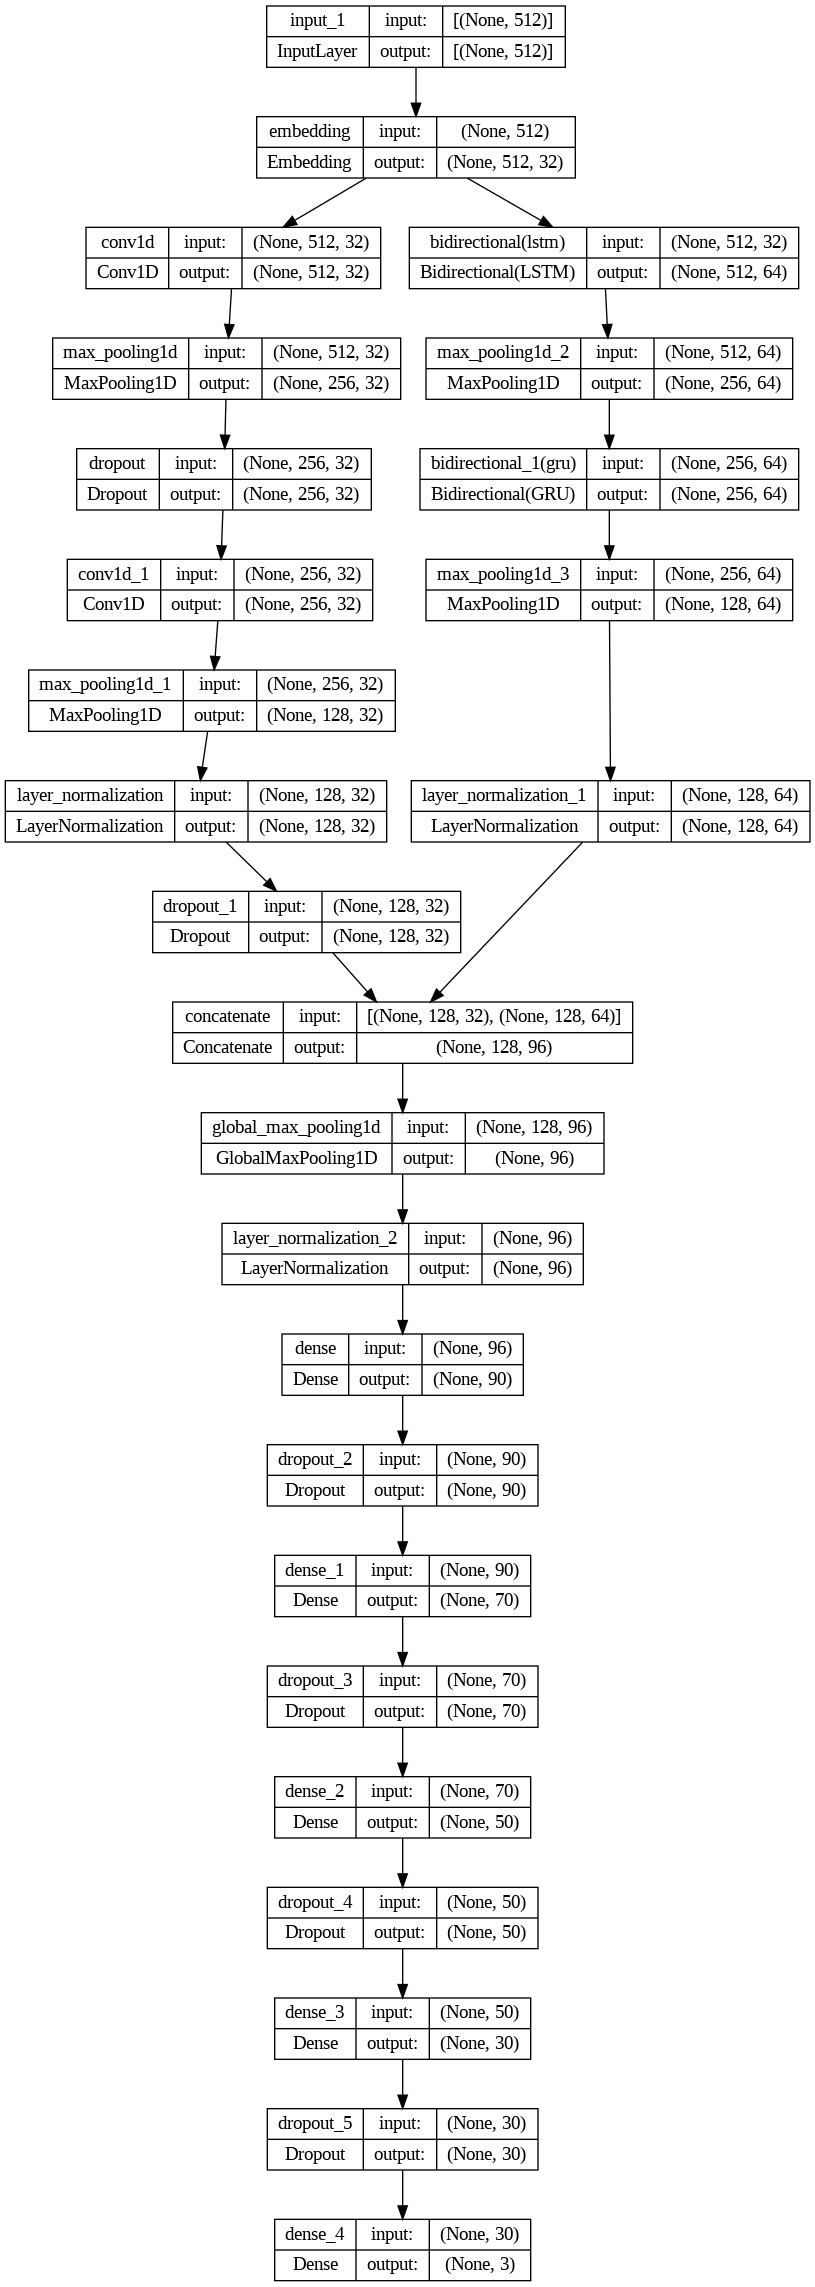

In [15]:
dot_img_file = '/content/drive/MyDrive/Colab Notebooks/data_uit-vsmec/model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

#Define Model CheckPoint & Training

In [16]:
callback_model = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/data_uit-vsmec/model_cnn_bilstm.h5', monitor='val_loss')
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 128, callbacks = [callback_model])

Epoch 1/10
78/78 [==============================] - ETA: 0s - loss: 1.1000 - accuracy: 0.3771

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 40s 259ms/step - loss: 1.1000 - accuracy: 0.3771 - val_loss: 1.0832 - val_accuracy: 0.4098
Epoch 2/10
78/78 [==============================] - 12s 152ms/step - loss: 1.0848 - accuracy: 0.4028 - val_loss: 1.0728 - val_accuracy: 0.4066
Epoch 3/10
78/78 [==============================] - 8s 103ms/step - loss: 1.0329 - accuracy: 0.4435 - val_loss: 0.9408 - val_accuracy: 0.5119
Epoch 4/10
78/78 [==============================] - 7s 95ms/step - loss: 0.8755 - accuracy: 0.5753 - val_loss: 0.8681 - val_accuracy: 0.6053
Epoch 5/10
78/78 [==============================] - 8s 102ms/step - loss: 0.7274 - accuracy: 0.6889 - val_loss: 0.9146 - val_accuracy: 0.6025
Epoch 6/10
78/78 [==============================] - 6s 72ms/step - loss: 0.5706 - accuracy: 0.7781 - val_loss: 0.8679 - val_accuracy: 0.6360
Epoch 7/10
78/78 [==============================] - 7s 85ms/step - loss: 0.4608 - accuracy: 0.8330 - val_loss: 0.9691 - val_accuracy: 0.6421
Epoch 8/10
78/78 [

#Model Evaluation with Accuracy, Precision, Recall, F1-Score

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_hat = model.predict(X_test)
y_pred = np.argmax(y_hat, axis=1)
y_test_label =  np.argmax(y_test, axis=1)

# Tính accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_label, y_pred)
print('Accuracy: %f' % accuracy)
# Tính precision tp / (tp + fp)
precision = precision_score(y_test_label, y_pred, average='macro')
print('Precision: %f' % precision)
# Tính recall: tp / (tp + fn)
recall = recall_score(y_test_label, y_pred, average='macro')
print('Recall: %f' % recall)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_label, y_pred, average='macro')
print('F1 score: %f' % f1)

35/35 [==============================] - 2s 24ms/step
Accuracy: 0.634806
Precision: 0.632282
Recall: 0.645315
F1 score: 0.634654


# Inference Model With Input Test

In [18]:
def preprocess_raw_input(raw_input, tokenizer):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  print("Text preprocessed:", input_text_pre_accent)
  tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
  vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen = 512)
  return vec_data

def inference_model(input_feature, model):
  output = model(input_feature).numpy()[0]
  result = output.argmax()
  conf = float(output.max())
  label_dict = {'tiêu cực':0, 'trung lập':1, 'tích cực':2}
  label = list(label_dict.keys())
  return label[int(result)], conf

def prediction(raw_input, tokenizer, model):
  input_model = preprocess_raw_input(raw_input, tokenizer_data)
  result, conf = inference_model(input_model, model)

  return result, conf

my_model = generate_model()
my_model = load_model('/content/drive/MyDrive/Colab Notebooks/data_uit-vsmec/model_cnn_bilstm.h5')

with open(r"/content/drive/MyDrive/Colab Notebooks/data_uit-vsmec/tokenizer_data.pkl", "rb") as input_file:
  my_tokenizer = pickle.load(input_file)

print(prediction("đánh chết mẹ mày giờ", my_tokenizer, my_model))


Text preprocessed: đánh chết mẹ mày giờ
('tiêu cực', 0.9577890634536743)


In [19]:
while(True):
  text = input()
  if text == "end":
      break
  else:
      print(prediction(text, my_tokenizer, my_model)[0]+'\n')

duma đập mày giờ
Text preprocessed: duma đập mày giờ
tiêu cực

end
